In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

In [4]:
forecast_data = pd.read_excel('data.xlsx', sheet_name = 'Forecasted Consumption')
rates = pd.read_excel('data.xlsx', sheet_name='Rates')
rates = rates.fillna(np.inf)
meter_list = pd.read_excel('data.xlsx', sheet_name='Meter List')

### 1. Calculating total consumption and cost for the given data

In [274]:
#Joining consumption data with meter list
start = timer()
temp = forecast_data.merge(meter_list, on = 'Meter ID', how = 'left')

#Unique periods and consumption ranges
periods = rates['Date'].unique()
aq_range = rates['Annual Quantity (Min)'].unique()

cond = [(aq_range[0] <= temp['Annual Quantity (kWh)'].values) & (temp['Annual Quantity (kWh)'].values < aq_range[1]),
(aq_range[1] <= temp['Annual Quantity (kWh)'].values) & (temp['Annual Quantity (kWh)'].values < aq_range[2]),
(temp['Annual Quantity (kWh)'].values > aq_range[2])]
choice = aq_range

#Creating Annual Quantity and Date to join Rate Table
temp['Annual Quantity (Min)'] = np.select(cond, choice)

for i in range(len(periods)-1):
    temp['Date'][np.where((periods[i] <= temp['Date']) & (temp['Date'] < periods[i+1]))[0]] = periods[i]

#Joining Rate Table with Consumption to obtain correct rates per row
merged_data = temp.merge(rates, how = 'left')
merged_data['Cost in GBP'] = (merged_data['kWh'] * merged_data['Rate (p/kWh)']) * 0.01

#Return Total Consumption and Cost in GBP for all meters
print(merged_data[['Meter ID', 'kWh','Cost in GBP']].groupby('Meter ID').sum().round(2))
stop = timer()
print('Time elapsed: ', round((stop - start)*1000, 2), 'ms')

                 kWh  Cost in GBP
Meter ID                         
10588707    122450.0        28.50
10626610    303558.0        88.24
1000000603   24674.0         8.27
Time elapsed:  49.85 ms


### 2. Function to generate random list of meters

In [275]:
# Part 2
exit_zone = rates['Exit Zone'].unique() #Fetch unique exit zones
def generate_meters(length):
    """
    Function to generate valid meters of given length
    Returns meter table with Meter ID, Exit Zone and Annual Quantity in kWh
    """
    
    meters = pd.DataFrame(index=range(length), columns=['Meter ID', 'Exit Zone', 'Annual Quantity (kWh)'])
    meters['Meter ID'] = [np.random.randint(0,100000) for i in range(length)]
    meters['Exit Zone'] = [exit_zone[np.random.randint(0,len(exit_zone))] for i in range(length)]
    meters['Annual Quantity (kWh)'] = [np.random.randint(0, 1000000) for i in range(length)]
    return meters

### 3. Function to generate consumption data for a given list of meters for a fixed period

In [276]:
# Part 3
def generate_consumption(meters, start, end):

    """ 
    Function to generate mock consumption data for a given meter list, start and end date
    Takes a list of meters, annual consumption per meter and generates valid consumption data in appropriate ranges

    """

    n_days = (end - start).days
    consumption_data = pd.DataFrame(index = range(len(meters)*n_days), columns = ['Date', 'Meter ID', 'kWh'])
    dates = []
    
    for i in range(len(meters)):
        dates += [start + timedelta(days=x) for x in range(n_days)]

    consumption_data['Date'] = dates

    meter_id = []
    for i in range(len(meters)):
        meter_id += [meters['Meter ID'][i] for j in range(n_days)]
    
    consumption_data['Meter ID'] = meter_id
    kWh = []
    for i in range(len(meters)):
        daily_avg = meters['Annual Quantity (kWh)'][i]/365
        kWh += [ daily_avg + (np.random.randint(-5,5)*0.1*daily_avg) for j in range(n_days) ]

    consumption_data['kWh'] = kWh

    return consumption_data

### 4. Function to calculate total costs and consumption 

In [277]:
def calculate_total(meters, consumption, rates):
    
    """
    Function to calculate total Transportation Costs given a list of meters, consumption data and rate table

    Returns DataFrame with MeterID, total consumption for entire period (kWh) and total cost (GBP)
    """
    
    
    temp = consumption.merge(meters, on = 'Meter ID', how = 'left')

    
    periods = rates['Date'].unique()
    aq_range = rates['Annual Quantity (Min)'].unique()

    cond = [(aq_range[0] <= temp['Annual Quantity (kWh)'].values) & (temp['Annual Quantity (kWh)'].values < aq_range[1]),
    (aq_range[1] <= temp['Annual Quantity (kWh)'].values) & (temp['Annual Quantity (kWh)'].values < aq_range[2]),
    (temp['Annual Quantity (kWh)'].values > aq_range[2])]
    choice = aq_range

    
    temp['Annual Quantity (Min)'] = np.select(cond, choice)

    for i in range(len(periods)-1):
        temp['Date'][np.where((periods[i] <= temp['Date']) & (temp['Date'] < periods[i+1]))[0]] = periods[i]

    
    merged_data = temp.merge(rates, how = 'left')
    merged_data['Cost in GBP'] = (merged_data['kWh'] * merged_data['Rate (p/kWh)']) * 0.01

    #Return Total Consumption and Cost in GBP for all meters
    return merged_data[['Meter ID', 'kWh','Cost in GBP']].groupby('Meter ID').sum().round(2)

In [278]:
#Output for 10 random meters for a period of 2 years
n = 10
meters = generate_meters(length = n)
start = datetime(2020,10,1)
end = datetime(2022,10,1)
consumption = generate_consumption(meters, start, end)
calculate_total(consumption, meters, rates)

,kWh,Cost in GBP
Meter ID,,
12455,512132.34,150.75
20553,213474.88,64.09
28378,94886.72,32.05
37792,109346.88,36.81
57652,1763842.71,4334.88
58096,758279.81,227.65
73309,1236076.81,370.95
74390,619893.16,145.56
90564,1621289.30,4113.35


In [280]:
#Sample runtime for 100 meters
n = 100
meters = generate_meters(length = n)
start = datetime(2020,10,1)
end = datetime(2022,10,1)
consumption = generate_consumption(meters, start, end)
%timeit calculate_total(consumption, meters, rates)

69.6 ms ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [204]:
#Part 5
def benchmark():
    """ 
    Function to generate performance benchmark data for combinations of durations and no. of meters
    Returns two lists -> table_size and delta
    """
    delta = []
    table_size = []
    for n_years in range(1,5):
        for n in range(5, 200, 5):
            meters = generate_meters(length = n)
            start = datetime(2020,4,1)
            end = datetime(2020 + n_years,4,1)
            consumption = generate_consumption(meters, start, end)
            tstart = timer()
            calculate_total(meters, consumption, rates)
            tstop = timer()
            delta.append(round((tstop - tstart)*1000, 2))
            table_size.append(len(consumption))

    return table_size, delta

Text(0, 0.5, 'Execution Time (ms)')

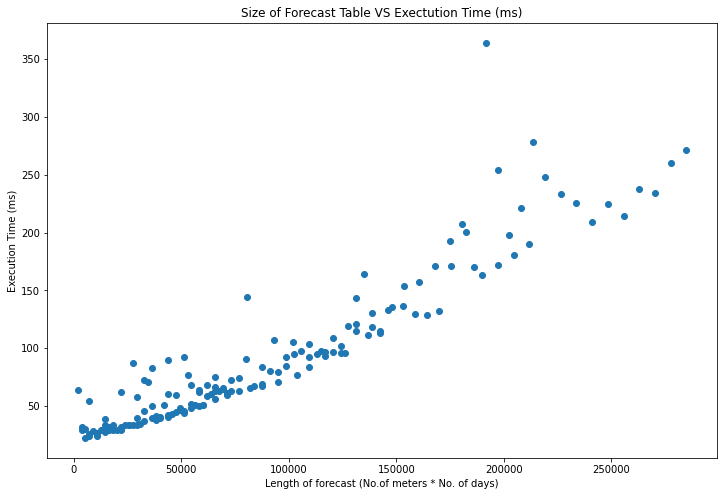

In [203]:
import matplotlib.pyplot as plt
table_size, delta = benchmark()
plt.figure(figsize=(12,8))
plt.scatter(table_size, delta)
plt.title('Size of Forecast Table VS Exectution Time (ms)')
plt.xlabel('Length of forecast (No.of meters * No. of days)')
plt.ylabel('Execution Time (ms)')

In [293]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [294]:
%lprun -f calculate_total calculate_total(meters, consumption, rates)

Timer unit: 1e-07 s

Total time: 0.0974514 s
File: <ipython-input-277-aa41fa40277f>
Function: calculate_total at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def calculate_total(meters, consumption, rates):
     2                                               
     3                                               """
     4                                               Function to calculate total Transportation Costs given a list of meters, consumption data and rate table
     5                                           
     6                                               Returns DataFrame with MeterID, total consumption for entire period (kWh) and total cost (GBP)
     7                                               """
     8                                               
     9                                               
    10         1     277094.0 277094.0     28.4      temp = consumption.merge(meters, 

## 5. Benchmarking observations:

- We can see that the function scales reasonably well with increase in the input size. The relationship resembles a nlog(n) curve.
- From the line-profiler results, we can observe that the almost 1/3 of the time is taken by the for loop used to match the data range. 
- But it was not possible to find a vectorized solution to match the dates from the rate table (due to unequal array sizes)

- The merge operations done on the tables also take up a considerable percentage of the execution time. But compared to other alternatives: searching for the appropriate row from the rate table using the np.where function with conditional statements or direct pandas indexing.

- The final return statement that uses groupby function based on Meter ID.   

### Possible improvements
- Look into operations that can be vectorized 
- Using Cython instead of python for loops
- Making use of parallel computing using tools like Dask